# Titanic K nearest neighbors

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import pandas as pd
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

sns.set()

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames.
fname_train = "train.csv"
fname_test = "test.csv"

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    pass
else:
    dirname = "/kaggle/input/titanic/"
    fname_train = dirname + fname_train
    fname_test = dirname + fname_test

In [2]:
titanic = pd.read_csv(fname_train)
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

# Pretend we already know for sure that these are unimportant:
unnecessary = ["PassengerId", "Name","SibSp","Parch","Ticket", "Cabin", "Embarked"]
#unnecessary = ["PassengerId", "Name","Ticket", "Embarked"]
unnecessary = ["PassengerId", "Name","Ticket", "Embarked", "Cabin"]

titanic.drop(unnecessary, inplace=True, axis=1)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.000000,1,0,7.2500
1,1,1,female,38.000000,1,0,71.2833
2,1,3,female,26.000000,0,0,7.9250
3,1,1,female,35.000000,1,0,53.1000
4,0,3,male,35.000000,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000
887,1,1,female,19.000000,0,0,30.0000
888,0,3,female,29.699118,1,2,23.4500
889,1,1,male,26.000000,0,0,30.0000


In [3]:
class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic.index, columns=titanic.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

sex_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
])

fare_pip = Pipeline([
    ("fare_mean", SimpleImputer(strategy="mean")),
    ('fare_std', StandardScaler())
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_pip = Pipeline([
    ('age_std', StandardScaler())
])

parch_pip = Pipeline([
    ('parch_std', StandardScaler())
])

sibsp_pip = Pipeline([
    ('sibsp_std', StandardScaler())
])

add_attrs = Pipeline([
    ("cabin_fill", SimpleImputer(strategy="most_frequent")),
    ("add_cabin_letters", CabinLetterOnly())
])

# new = add_attrs.fit_transform(titanic.values)
# titanic = pd.DataFrame(new, index=titanic.index, columns=titanic.columns.union(pd.Index(["Cabin_letter"]), sort=False))
# titanic.drop(["Cabin"], axis=1, inplace=True)

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

attr_pip = ColumnTransformer([
    #("passthrough", "passthrough", ["Pclass"]),
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"]),
    ("age", fare_pip, ["Age"]),
    #("parch", parch_pip, ["Parch"]),
    #("sibsp", sibsp_pip, ["SibSp"]),
    #("cabin_add", add_attrs, ["Cabin"]),
    #("cabin_trans", cabin_pip, ["Cabin_letter"]),
], remainder="drop")

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_ix, test_ix in split.split(titanic, titanic["Sex"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

In [5]:
titanic_labels = titanic["Survived"].astype(int)
strat_train_labels = strat_train["Survived"].astype(int)
strat_devtest_labels = strat_devtest["Survived"].astype(int)
strat_train.drop("Survived", inplace=True, axis=1)
strat_devtest.drop("Survived", inplace=True, axis=1)

In [6]:
strat_train_prep = attr_pip.fit_transform(strat_train)
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
skfold = StratifiedKFold(n_splits=5)

In [7]:
knb = KNeighborsClassifier(n_jobs=-1)
#knb.fit(strat_train_prep, strat_train_labels)
#best_knb = knb

svd_knb_pip = Pipeline([
    ("svd", TruncatedSVD()),
    ("knb", knb)
])

param_grid = [
    {"svd__n_components" : [2,3], "knb__n_neighbors" : [3,5,7,9,11,13]}
]


gridsearch = GridSearchCV(svd_knb_pip, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch.fit(strat_train_prep, strat_train_labels)
best_knb = gridsearch.best_estimator_

In [8]:
# pred_scores = cross_val_predict(best_knb, strat_train_prep, strat_train_labels, cv = skfold, method="decision_function")
# precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores)

# sns.lineplot(thresholds, precisions[:-1], color="r")
# sns.lineplot(thresholds, recalls[:-1], color="b")

In [9]:
pred = best_knb.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

array([[48,  9],
       [ 8, 25]])

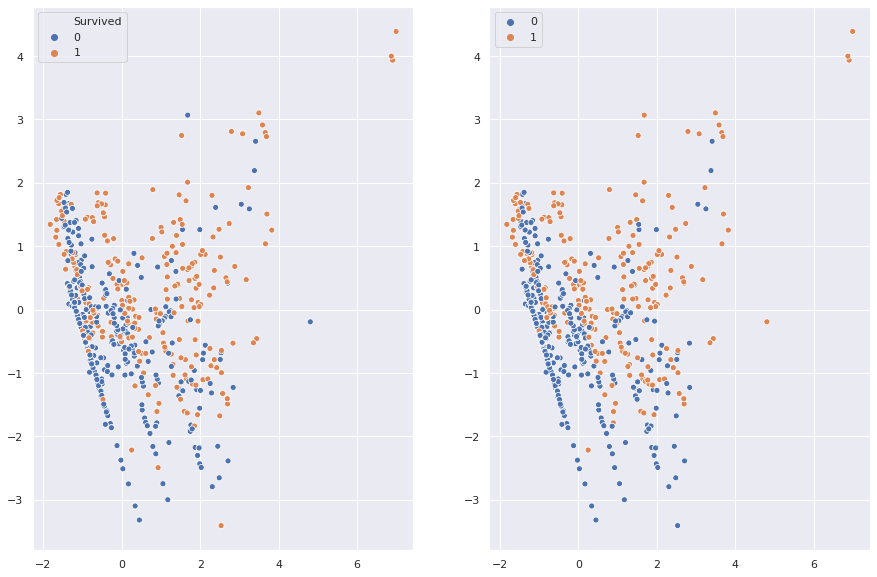

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
train_reduced = TruncatedSVD(n_components=2).fit_transform(strat_train_prep)
sns.scatterplot(x=train_reduced[:,0], y=train_reduced[:,1], hue=strat_train_labels, ax=ax[0])
pred = best_knb.predict(strat_train_prep)
sns.scatterplot(x=train_reduced[:,0], y=train_reduced[:,1], hue=pred, ax=ax[1])

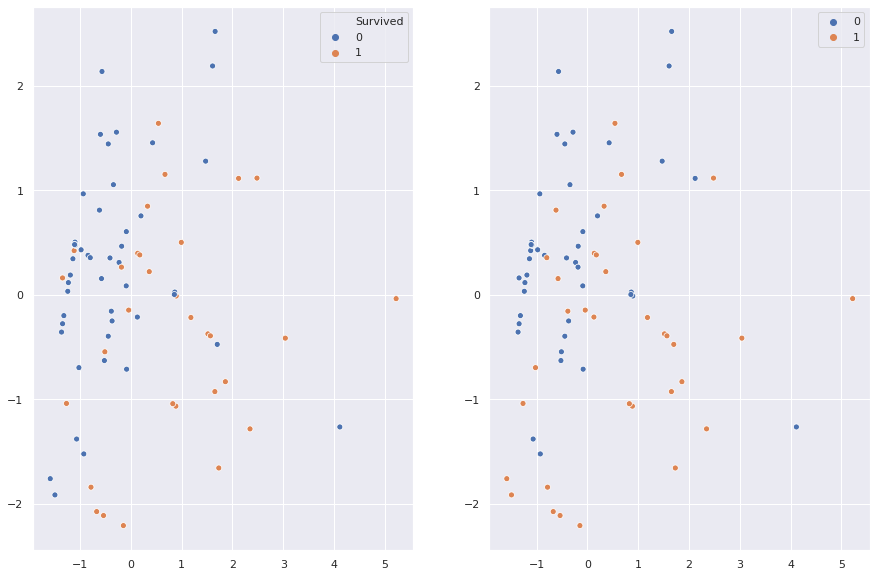

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
devtest_reduced = TruncatedSVD(n_components=2).fit_transform(strat_devtest_prep)
sns.scatterplot(x=devtest_reduced[:,0], y=devtest_reduced[:,1], hue=strat_devtest_labels, ax=ax[0])
pred = best_knb.predict(strat_devtest_prep)
sns.scatterplot(x=devtest_reduced[:,0], y=devtest_reduced[:,1], hue=pred, ax=ax[1])

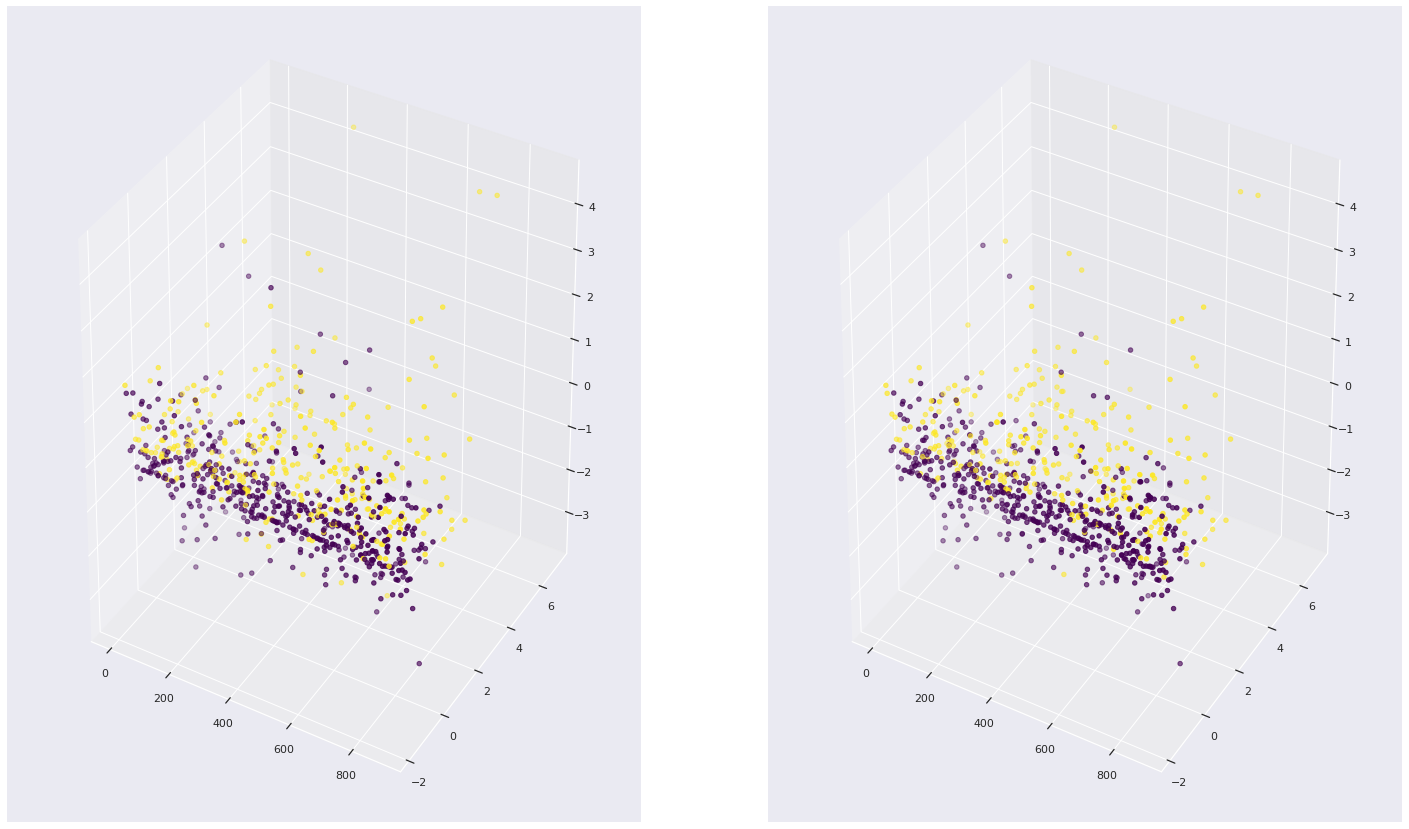

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(25,15), subplot_kw={"projection" : "3d"})
train_reduced = TruncatedSVD(n_components=2).fit_transform(strat_train_prep)
ax[0].scatter3D(xs = strat_train.index, ys=train_reduced[:,0], zs=train_reduced[:,1], c=strat_train_labels,
               cmap="viridis")
pred = best_knb.predict(strat_train_prep)
ax[1].scatter3D(xs = strat_train.index, ys=train_reduced[:,0], zs=train_reduced[:,1], c=pred,
               cmap="viridis")

In [13]:
best_model = best_knb 
best_model

Pipeline(memory=None,
         steps=[('svd',
                 TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
                              random_state=None, tol=0.0)),
                ('knb',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)

In [14]:
full_train = titanic.drop("Survived", axis=1)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

test = pd.read_csv(fname_test)
test_prep = attr_pip.fit_transform(test)
titanic_prep = attr_pip.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_model.predict(test_prep)


# survival_proba = best_model.predict_proba(test_prep)
# survival_pred = survival_proba > thresh
# survival_pred = survival_pred[:, 1].astype(int)


survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
